In [1]:
#Shengchao, Juan 
#Apr.2021
#v1.1
#
#Edited by Aidan, added multiple iterations
#Jun.2021
#July 15, new version, Juan, cleaning the code


import numpy as np
import pandas as pd
import scipy
import scipy.stats
import scipy.optimize as op
from scipy.optimize import curve_fit
import os
from scipy.integrate import quad 
import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
#from multihist import Histdd


import time
import sys
import tqdm

import math
import random
import numba

from scipy.stats import norm

import struct

In [2]:
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

In [163]:
#read file for multiple channels
channels=4
dmafiforeq=65534 #requested number of elements of the dma fifo in the PC code, set to 2xDMA FIFO depth
iterations=10 #number of iterations of the PC code, if labview says x iterations, there are x+1
fileName = '/Users/DAQ/Desktop/NIMultiple/binaryNEW_trigger_mult.dat'
data_raw = numpy.fromfile(fileName, dtype="<d") #> for big endian, < for little, d for double (already come as voltages), first element of every iteration removed
print("binary file received is size "+str(data_raw.shape))
rows=int(len(data_raw)/channels)
#create matrix where each column is an iteration
iter_matrix=np.reshape(data_raw,(iterations,(dmafiforeq*channels)+1))
iter_matrix=np.delete(iter_matrix,(0), axis=1) #deleting first column, which is the first value read per iteration
#creating one array per channel: first 65534*(x+1) elements in each row corresponds to channel x, x from 0 to channels


temp0=np.reshape(iter_matrix[:,0:dmafiforeq],(1,dmafiforeq*iterations))
temp1=np.reshape(iter_matrix[:,dmafiforeq:2*dmafiforeq],(1,dmafiforeq*iterations))
temp2=np.reshape(iter_matrix[:,2*dmafiforeq:3*dmafiforeq],(1,dmafiforeq*iterations))
temp3=np.reshape(iter_matrix[:,3*dmafiforeq:4*dmafiforeq],(1,dmafiforeq*iterations))

channels=np.transpose(np.array([temp0[0],temp1[0],temp2[0],temp3[0]])) #1 channel per column
print(np.shape(channels))

data=pd.DataFrame(channels, columns=None) #channel 1 is labeled as 0, channel n is labeled as n-1

binary file received is size (2621370,)
(655340, 4)


In [173]:
data

,0,1,2,3,time_us
0,0.010620,-0.023682,-0.025269,-0.018799,0.0
1,0.052247,-0.023682,-0.025391,-0.019165,0.4
2,0.077150,-0.023926,-0.025757,-0.018921,0.8
3,0.079225,-0.023804,-0.025269,-0.018799,1.2
4,0.057740,-0.023926,-0.025147,-0.018921,1.6
...,...,...,...,...,...
655335,0.031250,-0.023560,-0.025513,-0.019043,262134.0
655336,0.075319,-0.023560,-0.025269,-0.018921,262134.4
655337,0.074464,-0.024048,-0.025269,-0.018921,262134.8
655338,0.029419,-0.023804,-0.025391,-0.019165,262135.2


In [181]:
data_time=data.time_us
data_time

0              0.0
1              0.4
2              0.8
3              1.2
4              1.6
            ...   
655335    262134.0
655336    262134.4
655337    262134.8
655338    262135.2
655339    262135.6
Name: time_us, Length: 655340, dtype: float64

In [164]:
sample_freq = 2.5  #MHz
data['time_us']= 1/sample_freq*data.index #us

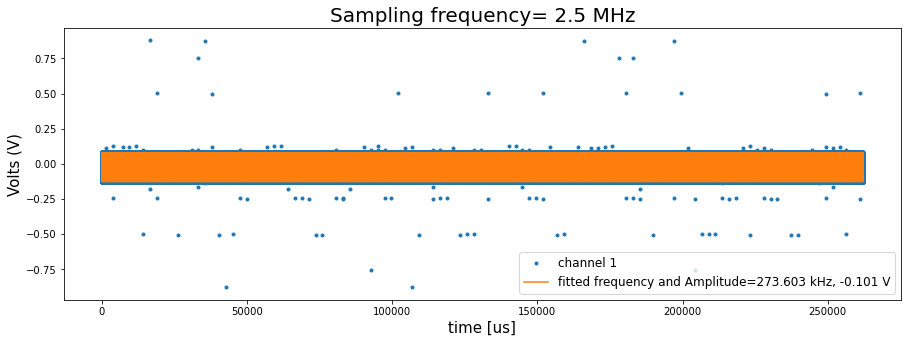

In [172]:
start=0#len(data[0])-300
end=len(data[0])
plt.figure(figsize=(15,5))
plt.title("Sampling frequency= "+str(sample_freq)+" MHz",size=20)

plt.plot(data['time_us'][start:end],data[0][start:end],label='channel 1',marker='.',linestyle='none')
#plt.plot(data['time_us'],data[1],label='channel 2',marker='.',linestyle='none')
#plt.plot(data['time_us'],data[2],label='channel 3',marker='.',linestyle='none')
#plt.plot(data['time_us'],data[3],label='channel 4',marker='.',linestyle='none')

plt.ylabel('Volts (V)',size=15)
plt.xlabel('time [us]',size=15)

fit_result= fit_sin(data['time_us'],data[0])
sin_func=fit_result['fitfunc']

plt.plot(data['time_us'][start:end],sin_func(data['time_us'][start:end]), label='fitted frequency and Amplitude=%.3f kHz, %.3f V'%(fit_result['freq']*1000,fit_result['amp']))
plt.legend(fontsize=12, loc='best')

plt.show()

In [170]:
#number of peaks found vs expected
import scipy.signal
peaks=scipy.signal.find_peaks(sin_func(data['time_us'][start:end]))
number_found=len(peaks[0])
#print(peaks,number_found)

In [171]:
input_freq=273600 #Hz or cycles per sec
sampling_points=np.shape(channels)[0] #per channel
sampling_freq=2500000#clock rate in LabView FPGA
number_expected=int(sampling_points*input_freq/sampling_freq)
print(number_expected)
cycles_lost=abs(number_expected-number_found)
print(cycles_lost)

71720
71687


In [168]:
#points lost in the acquiring process: each cycle takes 1/freq seconds to happen, and we take sampling_rate data points per second
points_lost=cycles_lost*sampling_freq/input_freq
print(points_lost)

9.137426900584796
